Class distribution after SMOTE: Dyslexia
0    2603
1    2603
Name: count, dtype: int64
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       649
           1       0.62      0.39      0.48        80

    accuracy                           0.91       729
   macro avg       0.77      0.68      0.71       729
weighted avg       0.89      0.91      0.90       729

Confusion Matrix:
[[630  19]
 [ 49  31]]


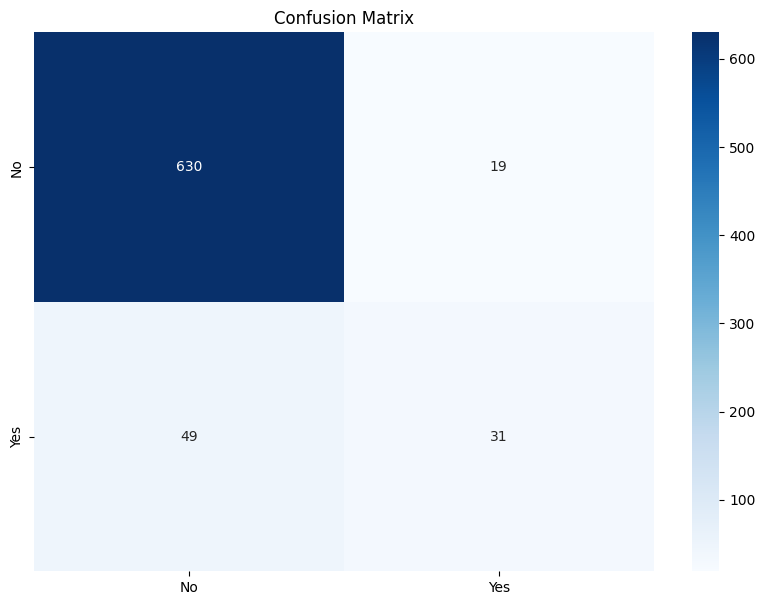

Cross-validation mean: 0.887
Cross-validation variance: 0.000
Cross-validation standard deviation: 0.008


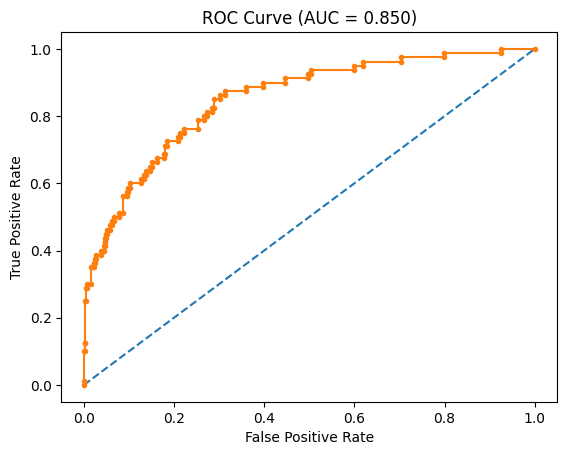

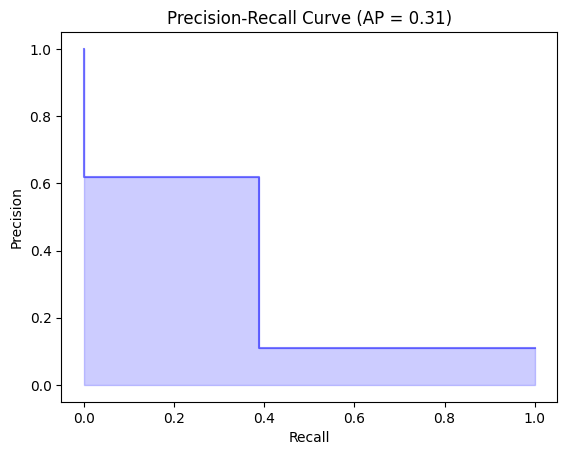

F1 Score: 0.477


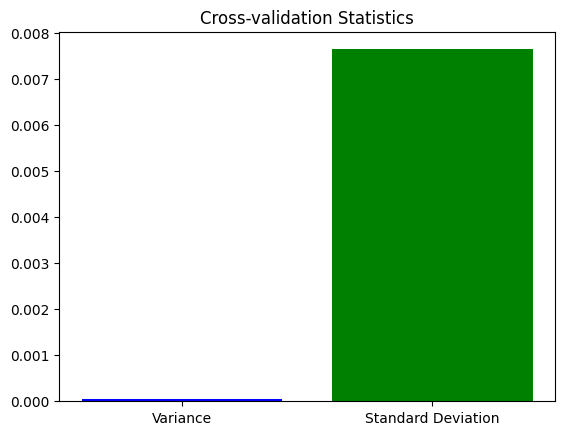

In [48]:
# -*- coding: utf-8 -*-
"""
Analisi di un dataset sulla dislessia utilizzando Random Forest
"""

# Import delle librerie necessarie
import numpy as np
import pandas as pd
import csv
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score,
    roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
)
from imblearn.over_sampling import SMOTE

# Funzione per la pulizia e trasformazione dei dati

def clean_data(data):
    """Converte le colonne stringa in numerico e mappa i valori categorici."""
    for col in data.columns:
        data[col] = data[col].astype('string')
        data[col] = data[col].astype('float', errors='ignore')

    data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 2})
    data['Dyslexia'] = data['Dyslexia'].map({'No': 0, 'Yes': 1})
    data['Nativelang'] = data['Nativelang'].map({'No': 0, 'Yes': 1})
    data['Otherlang'] = data['Otherlang'].map({'No': 0, 'Yes': 1})

# Caricamento dataset
desktop_data = pd.read_csv("/content/Dyslexia_dataset.csv", sep=';', encoding='utf-8')
clean_data(desktop_data)

# Selezione delle colonne di interesse
features = ['Gender', 'Nativelang', 'Otherlang', 'Age', 'Dyslexia']
for i in range(30):
    if (i in list(range(12)) + list(range(13, 17)) + [21, 22, 29]):
        for metric in ['Clicks', 'Hits', 'Misses', 'Score', 'Accuracy', 'Missrate']:
            features.append(f'{metric}{i+1}')

desktop_data = desktop_data[features]

# Separazione delle variabili dipendenti e indipendenti
y = desktop_data['Dyslexia']
X = desktop_data.drop(columns=['Dyslexia'])

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bilanciamento delle classi con SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", y_train_sm.value_counts())

# Creazione e addestramento del modello Random Forest
weights = {0: 1, 1: 6}  # Peso maggiore alla classe 1
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=6, class_weight=weights, random_state=42)
rf_clf.fit(X_train, y_train)

# Predizione e valutazione del modello
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Visualizzazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred_rf)
df_cm = pd.DataFrame(cm, index=['No', 'Yes'], columns=['No', 'Yes'])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Valutazione con cross-validation
cv_scores = cross_val_score(rf_clf, X, y, cv=5)
print(f'Cross-validation mean: {np.mean(cv_scores):.3f}')
print(f'Cross-validation variance: {np.var(cv_scores):.3f}')
print(f'Cross-validation standard deviation: {np.std(cv_scores):.3f}')

# Calcolo e visualizzazione della curva ROC
probs = rf_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.3f})')
plt.show()

# Calcolo e visualizzazione della curva Precision-Recall
average_precision = average_precision_score(y_test, y_pred_rf)
precision, recall, _ = precision_recall_curve(y_test, y_pred_rf)
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

# Calcolo del punteggio F1
f1 = f1_score(y_test, y_pred_rf)
print(f'F1 Score: {f1:.3f}')

# Visualizzazione varianza e deviazione standard dei cv_scores
cv_stats = {'Variance': np.var(cv_scores), 'Standard Deviation': np.std(cv_scores)}
names, values = zip(*cv_stats.items())
plt.bar(names, values, color=['blue', 'green'])
plt.title('Cross-validation Statistics')
plt.show()
